# Diabetes Self-Management Dashboard

This notebook simulates a simple diabetes self-management application.

It shows:
- Glucose trends over time
- Daily and weekly summaries
- Medication adherence
- Alerts that combine a clinical view and a patient-friendly explanation

All data used here is synthetic and for coursework / demonstration only.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

In [8]:
# Adjust paths if needed; this assumes the notebook is in notebooks/ and data is in ../data/
glucose = pd.read_csv("../data/glucose_readings.csv")
meds = pd.read_csv("../data/medication_log.csv")

glucose.head(), meds.head()

(         date   time  glucose_mgdl
 0  2024-07-01  08:00           134
 1  2024-07-01  12:00           168
 2  2024-07-01  20:00           145
 3  2024-07-02  08:00           122
 4  2024-07-02  12:00           155,
          date medication   dose taken
 0  2024-07-01  Metformin  500mg   yes
 1  2024-07-02  Metformin  500mg    no
 2  2024-07-03  Metformin  500mg   yes)

In [9]:
# Combine date + time into a single datetime for glucose readings
glucose["datetime"] = pd.to_datetime(glucose["date"] + " " + glucose["time"])
glucose["date"] = pd.to_datetime(glucose["date"])
glucose = glucose.sort_values("datetime")

# Parse medication dates
meds["date"] = pd.to_datetime(meds["date"])

glucose.head()

,date,time,glucose_mgdl,datetime
0,2024-07-01,08:00,134,2024-07-01 08:00:00
1,2024-07-01,12:00,168,2024-07-01 12:00:00
2,2024-07-01,20:00,145,2024-07-01 20:00:00
3,2024-07-02,08:00,122,2024-07-02 08:00:00
4,2024-07-02,12:00,155,2024-07-02 12:00:00


In [10]:
def classify_glucose(value):
    """Classify glucose into Low / Target Range / High based on mg/dL thresholds."""
    if value < 70:
        return "Low"
    elif value <= 180:
        return "Target Range"
    else:
        return "High"

def add_glucose_categories(df):
    df = df.copy()
    df["category"] = df["glucose_mgdl"].apply(classify_glucose)
    return df

def calculate_daily_stats(df):
    stats = (
        df.groupby(df["date"].dt.date)["glucose_mgdl"]
        .agg(["mean", "min", "max"])
        .rename(columns={"mean": "avg", "min": "min", "max": "max"})
    )
    return stats

def compute_adherence(meds_df):
    """Return adherence rate (0–1)."""
    if meds_df.empty:
        return np.nan
    return meds_df["taken"].str.lower().eq("yes").mean()


In [12]:
glucose = add_glucose_categories(glucose)
daily_stats = calculate_daily_stats(glucose)
adherence = compute_adherence(meds)

glucose.head(), daily_stats, adherence

(        date   time  glucose_mgdl            datetime      category
 0 2024-07-01  08:00           134 2024-07-01 08:00:00  Target Range
 1 2024-07-01  12:00           168 2024-07-01 12:00:00  Target Range
 2 2024-07-01  20:00           145 2024-07-01 20:00:00  Target Range
 3 2024-07-02  08:00           122 2024-07-02 08:00:00  Target Range
 4 2024-07-02  12:00           155 2024-07-02 12:00:00  Target Range,
                    avg  min  max
 date                            
 2024-07-01  149.000000  134  168
 2024-07-02  138.666667  122  155
 2024-07-03  142.666667  118  160,
 0.6666666666666666)

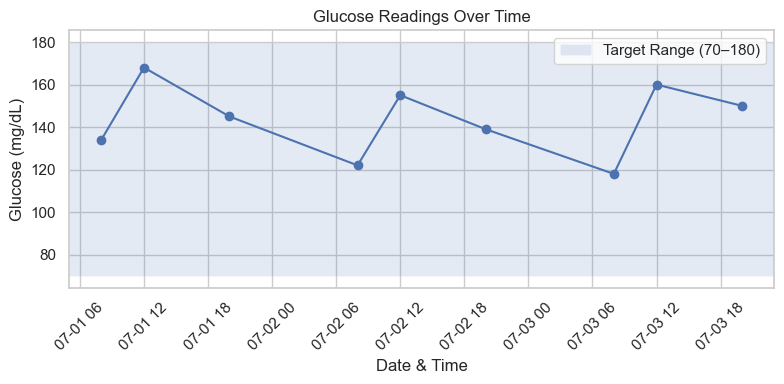

In [14]:
fig, ax = plt.subplots()

ax.plot(glucose["datetime"], glucose["glucose_mgdl"], marker="o")

# Highlight target range (70–180 mg/dL)
ax.axhspan(70, 180, alpha=0.15, label="Target Range (70–180)")

ax.set_title("Glucose Readings Over Time")
ax.set_xlabel("Date & Time")
ax.set_ylabel("Glucose (mg/dL)")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


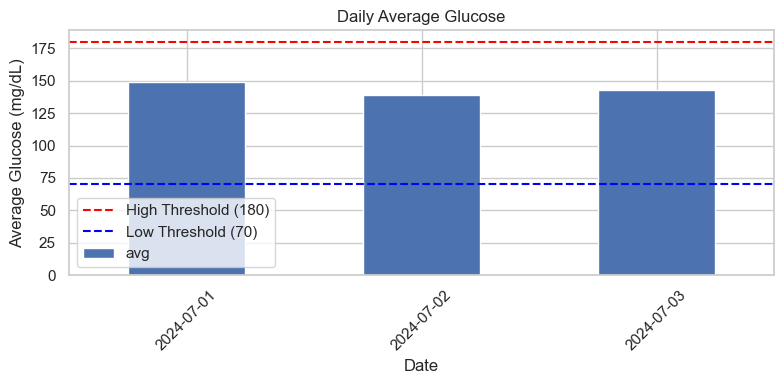

In [16]:
fig, ax = plt.subplots()

daily_stats["avg"].plot(kind="bar", ax=ax)

ax.axhline(180, color="red", linestyle="--", label="High Threshold (180)")
ax.axhline(70, color="blue", linestyle="--", label="Low Threshold (70)")

ax.set_title("Daily Average Glucose")
ax.set_xlabel("Date")
ax.set_ylabel("Average Glucose (mg/dL)")
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


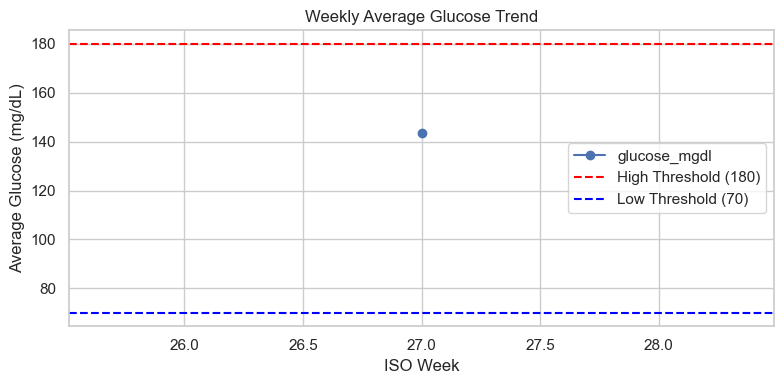

week
27    143.444444
Name: glucose_mgdl, dtype: float64

In [18]:
glucose["week"] = glucose["date"].dt.isocalendar().week
weekly_trend = glucose.groupby("week")["glucose_mgdl"].mean()

fig, ax = plt.subplots()
weekly_trend.plot(kind="line", marker="o", ax=ax)

ax.set_title("Weekly Average Glucose Trend")
ax.set_xlabel("ISO Week")
ax.set_ylabel("Average Glucose (mg/dL)")
ax.axhline(180, color="red", linestyle="--", label="High Threshold (180)")
ax.axhline(70, color="blue", linestyle="--", label="Low Threshold (70)")
ax.legend()
plt.tight_layout()
plt.show()

weekly_trend


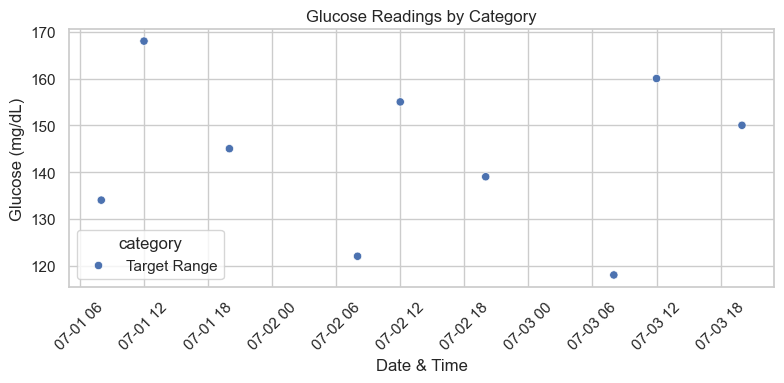

In [20]:
fig, ax = plt.subplots()

sns.scatterplot(
    data=glucose,
    x="datetime",
    y="glucose_mgdl",
    hue="category",
    style="category",
    ax=ax
)

ax.set_title("Glucose Readings by Category")
ax.set_xlabel("Date & Time")
ax.set_ylabel("Glucose (mg/dL)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Medication adherence rate: 66.67%


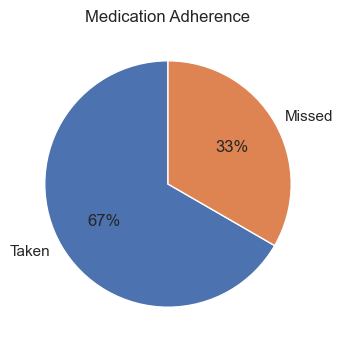

In [22]:
adherence_rate = adherence
miss_rate = 1 - adherence_rate if pd.notna(adherence_rate) else np.nan

print(f"Medication adherence rate: {adherence_rate:.2%}")

fig, ax = plt.subplots()
ax.pie(
    [adherence_rate, miss_rate],
    labels=["Taken", "Missed"],
    autopct="%1.0f%%",
    startangle=90
)
ax.set_title("Medication Adherence")
plt.show()


In [24]:
def max_consecutive_highs(df, threshold=180):
    """Return the maximum number of consecutive high readings."""
    highs = df["glucose_mgdl"] > threshold
    max_streak = 0
    current = 0
    for is_high in highs:
        if is_high:
            current += 1
            max_streak = max(max_streak, current)
        else:
            current = 0
    return max_streak

def detect_midday_pattern(df, threshold=180):
    """Check if midday readings (11:00-15:00) tend to be high."""
    df = df.copy()
    df["time_only"] = df["datetime"].dt.time
    midday = df[
        (df["datetime"].dt.hour >= 11) & 
        (df["datetime"].dt.hour <= 15)
    ]
    if midday.empty:
        return False, None
    mean_midday = midday["glucose_mgdl"].mean()
    return mean_midday > threshold, mean_midday

def generate_alerts(glucose_df, meds_df, high_threshold=180, low_threshold=70):
    alerts = []
    
    # Basic counts
    total_highs = (glucose_df["glucose_mgdl"] > high_threshold).sum()
    total_lows = (glucose_df["glucose_mgdl"] < low_threshold).sum()
    max_high_streak = max_consecutive_highs(glucose_df, high_threshold)
    
    # Midday pattern
    midday_flag, midday_mean = detect_midday_pattern(glucose_df, high_threshold)
    
    # Adherence
    adherence_rate = compute_adherence(meds_df)
    
    # Alert 1: Many highs
    if total_highs >= 3:
        alerts.append({
            "type": "recurrent_high_glucose",
            "clinical_message": f"{total_highs} readings above {high_threshold} mg/dL were observed.",
            "patient_message": "You had several higher glucose readings. It may help to review your meals, activity, and timing of your checks.",
        })
    
    # Alert 2: High streak
    if max_high_streak >= 2:
        alerts.append({
            "type": "consecutive_highs",
            "clinical_message": f"Maximum high-glucose streak: {max_high_streak} readings in a row.",
            "patient_message": "There were multiple high readings in a row. Consider checking closer to meals and talking with your care team if this continues.",
        })
    
    # Alert 3: Midday pattern
    if midday_flag:
        alerts.append({
            "type": "midday_pattern",
            "clinical_message": f"Mean midday glucose is {midday_mean:.1f} mg/dL, above the target range.",
            "patient_message": "Your midday glucose is running a bit high. You may want to look at lunch content or timing of medication.",
        })
    
    # Alert 4: Low adherence
    if pd.notna(adherence_rate) and adherence_rate < 0.8:
        alerts.append({
            "type": "low_adherence",
            "clinical_message": f"Medication adherence over the logged period is {adherence_rate:.1%}.",
            "patient_message": "You missed some doses of your medication. Setting reminders might help you stay on track.",
        })
    
    return alerts


In [26]:
alerts = generate_alerts(glucose, meds)

# Clinical summary
clinical_summary = {
    "total_readings": int(len(glucose)),
    "avg_glucose": float(glucose["glucose_mgdl"].mean()),
    "max_glucose": int(glucose["glucose_mgdl"].max()),
    "min_glucose": int(glucose["glucose_mgdl"].min()),
    "num_highs": int((glucose["glucose_mgdl"] > 180).sum()),
    "num_lows": int((glucose["glucose_mgdl"] < 70).sum()),
    "adherence_rate": float(adherence_rate) if pd.notna(adherence_rate) else None,
}

# Patient-friendly summary (simple text)
patient_summary = {
    "message": (
        f"Your average glucose over this period is about {clinical_summary['avg_glucose']:.0f} mg/dL. "
        f"You had {clinical_summary['num_highs']} higher readings and {clinical_summary['num_lows']} lower readings. "
        "The charts above can help you see when these are happening."
    )
}

clinical_summary, patient_summary, alerts


({'total_readings': 9,
  'avg_glucose': 143.44444444444446,
  'max_glucose': 168,
  'min_glucose': 118,
  'num_highs': 0,
  'num_lows': 0,
  'adherence_rate': 0.6666666666666666},
 {'message': 'Your average glucose over this period is about 143 mg/dL. You had 0 higher readings and 0 lower readings. The charts above can help you see when these are happening.'},
 [{'type': 'low_adherence',
   'clinical_message': 'Medication adherence over the logged period is 66.7%.',
   'patient_message': 'You missed some doses of your medication. Setting reminders might help you stay on track.'}])

In [28]:
# Prepare daily summary in a JSON-friendly format
daily_summary = daily_stats.reset_index().rename(columns={"index": "date"})
daily_summary["date"] = daily_summary["date"].astype(str)

weekly_trend_json = weekly_trend.reset_index().rename(columns={"week": "iso_week", "glucose_mgdl": "avg_glucose"})

output = {
    "clinical_summary": clinical_summary,
    "patient_summary": patient_summary,
    "alerts": alerts,
    "daily_summary": daily_summary.to_dict(orient="records"),
    "weekly_trends": weekly_trend_json.to_dict(orient="records"),
}

with open("../data/daily_summary.json", "w") as f:
    json.dump(daily_summary.to_dict(orient="records"), f, indent=2)

with open("../data/weekly_trends.json", "w") as f:
    json.dump(weekly_trend_json.to_dict(orient="records"), f, indent=2)

with open("../data/alerts.json", "w") as f:
    json.dump(alerts, f, indent=2)

print("Saved daily_summary.json, weekly_trends.json, and alerts.json in ../data/")


Saved daily_summary.json, weekly_trends.json, and alerts.json in ../data/


## Dashboard Summary

**Clinical view (for care teams):**
- Number of glucose readings, average, minimum, maximum
- Number of high and low readings
- Weekly patterns and adherence level
- Alerts around repeated highs, midday patterns, and missed doses

**Patient-friendly view:**
- Plain-language explanation of average glucose
- Simple feedback about high and low readings
- Suggestions to check meals, timing, and medication habits
- Encouragement to use the graphs to spot personal patterns

This notebook models the core logic behind a simple diabetes self-management application, combining analytics for clinicians with feedback that a patient could understand and use.
